## import needed libraries

In [1]:
import os.path as osp
import glob

import h5py
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib as mpl

hep.set_style(hep.style.CMS)

## load models and weights of the fully connected model

In [3]:
from models.model import Net
model_file = "models/v0/epoch-19.pt"
upuppi = Net(isFCN=True).to('cuda')
upuppi.load_state_dict(torch.load(model_file)['model'])
upuppi.eval()


Net(
  (vtx_encode): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (pfc_encode): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

## load the test datasets

In [4]:
from deepjet_geometric.datasets import UPuppiV0
from torch_geometric.data import DataLoader
BATCHSIZE = 30

data_test = UPuppiV0("/home/yfeng/UltimatePuppi/deepjet-geometric/data/test/")
test_loader = DataLoader(data_test, batch_size=BATCHSIZE, shuffle=True,
                         follow_batch=['x_pfc', 'x_vtx'])

### run the inference on the testing datasets, preparing the numpy arrays for plotting

In [5]:
final_truth = np.empty(0)
final_pred  = np.empty(0)
final_f_pt  = np.empty(0)
final_f_eta = np.empty(0)
final_f_phi = np.empty(0)
final_f_e   = np.empty(0)
final_f_pid = np.empty(0)
final_f_charge = np.empty(0)
final_f_inputz = np.empty(0)

            
counter = 0
for data in test_loader:
        counter += 1
        data = data.to('cuda')
        with torch.no_grad():
            out = upuppi(data.x_pfc,
                        data.x_vtx,
                        data.x_pfc_batch,
                        data.x_vtx_batch)
            
            tmp_pred = out[0][:,0].cpu().numpy()
            truth = data.y.cpu().numpy()
            pfcands = data.x_pfc.cpu().numpy()
            
            final_truth = np.concatenate((final_truth, truth),axis=0)
            final_pred  = np.concatenate((final_pred,tmp_pred),axis=0)
            final_f_pt  = np.concatenate((final_f_pt,pfcands[:,0]),axis=0)
            final_f_eta = np.concatenate((final_f_eta,pfcands[:,1]),axis=0)
            final_f_phi = np.concatenate((final_f_phi,pfcands[:,2]),axis=0)
            final_f_e = np.concatenate((final_f_e,pfcands[:,3]),axis=0)
            final_f_pid = np.concatenate((final_f_pid,pfcands[:,4]),axis=0)
            final_f_charge = np.concatenate((final_f_charge,pfcands[:,5]),axis=0)
            final_f_inputz = np.concatenate((final_f_inputz,pfcands[:,6]),axis=0)

print("counter: ", counter)

counter:  34


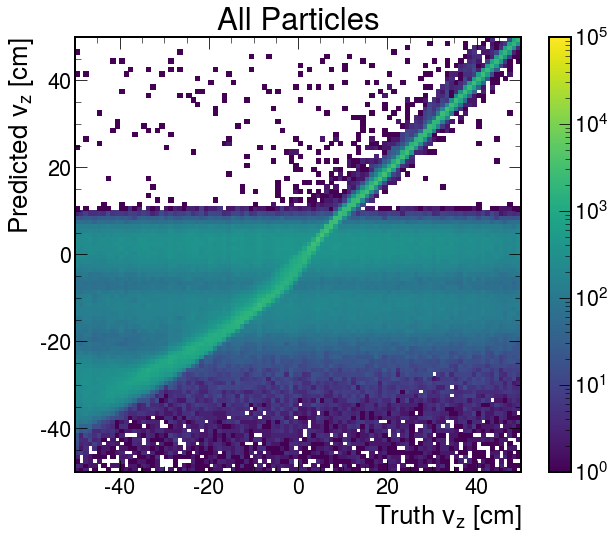

In [15]:
fig = plt.figure(figsize=(10,8))
a = plt.hist2d(final_truth, final_pred, bins=100, range=[[-50.0,50.0],[-50.0,50.0]], norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1,1e5)
plt.title('All Particles')
plt.xlabel(r'Truth $v_{z}$ [cm]')
plt.ylabel(r'Predicted $v_{z}$ [cm]')
plt.show()

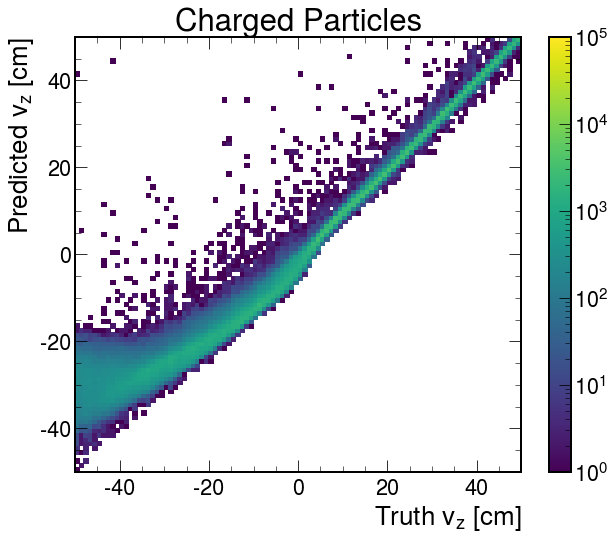

In [13]:
fig = plt.figure(figsize=(10,8))
a = plt.hist2d(final_truth[final_f_charge!=0], final_pred[final_f_charge!=0], bins=100, range=[[-50.0,50.0],[-50.0,50.0]], norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1,1e5)
plt.title('Charged Particles')
plt.xlabel(r'Truth $v_{z}$ [cm]')
plt.ylabel(r'Predicted $v_{z}$ [cm]')
plt.show()

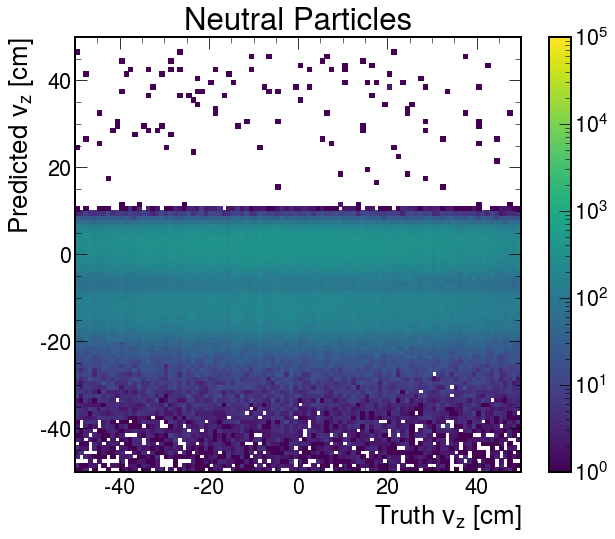

In [14]:
fig = plt.figure(figsize=(10,8))
a = plt.hist2d(final_truth[final_f_charge==0], final_pred[final_f_charge==0], bins=100, range=[[-50.0,50.0],[-50.0,50.0]], norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1,1e5)

plt.title('Neutral Particles')
plt.xlabel(r'Truth $v_{z}$ [cm]')
plt.ylabel(r'Predicted $v_{z}$ [cm]')
plt.show()